In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

In [2]:
data_path = '../../data/agg_unigram/'

In [3]:
fandom_list = [i for i in os.listdir(data_path) if 'tsv' in i]

In [5]:
df = pd.read_csv(os.path.join(data_path, fandom_list[0]), sep = '\t')

In [6]:
df.head(2)

,Unnamed: 0,Author,Hits,Kudos,Title,Words,UpdateDate,Bookmarks,Comments,Chapters,PublishDate,CompleteDate,completed_in_days,cos
0,0,firewolfsg,4067.0,30.0,Eye of the Beholder,1152.0,NaN,6,7,1,2609,2609.0,0.0,0.161426
1,1,Sioux,283.0,8.0,Merlin and the Owl,17578.0,NaN,1,4,1,1905,1905.0,0.0,0.095096


In [8]:
d = dict(zip(df.cos, df.Kudos))

In [9]:
x = [i for i in sorted(d.keys())]
y = [d[i] for i in sorted(d.keys())]

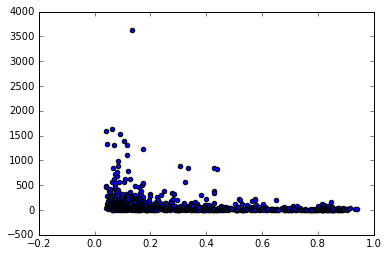

In [10]:
plt.scatter(x, y)

In [11]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

In [100]:
def create_normed_dfs(df):
    
    # Normalize effects of authors by turning kudos into z-score corresponding to works from this author
    # Seems not useful b/c many authors only have 1 work
#     author_list = df.Author.drop_duplicates().tolist()
#     combined = []
#     for author in author_list:
#         df_a = df[df.Author == author]
#         if len(df_a) > 1:
#             df_a['Kudos'] = (df_a['Kudos'] - df_a['Kudos'].mean())/df_a['Kudos'].std(ddof=0)
#             combined.append(df_a)        
#     df = pd.concat(combined)
#     df = df[df.Kudos != 0]

# #     Normalize by creating hits/kudos 
#     df = df[df.Hits != 0]
#     df = df[df.Kudos != 0]
#     df['Kudos/Hits'] = df['Kudos'].astype(float)/df['Hits'].astype(float)
    
#     Normalize by log scale
    df = df[df.Kudos != 0]
    df['Kudos'] = np.log(df['Kudos'])
    df = df[df.Hits != 0]
    df['Hits'] = np.log(df['Hits'])
    df['Kudos/Hits'] = df['Kudos'] - df['Hits']

#     # filter 0s
# #     df = df.fillna(0)

#     # turn into z scores
#     df['cos'] = df['cos'].astype(float)
#     df['cos'] = (df['cos'] - df['cos'].mean())/df['cos'].std(ddof=0)

    return df

In [101]:
def create_dict(fandom_list, field, binsize):
    dict_all = {}
    
    for f in fandom_list:
        df = pd.read_csv(os.path.join(data_path,f), sep = '\t')
        df = create_normed_dfs(df)
        # Make bins
        df.cos = df.cos.astype(float)
        min_cos = min(df.cos.tolist()) - 0.1
        max_cos = max(df.cos.tolist()) + 0.1
        dic = {}
        for i in np.arange(min_cos, max_cos, binsize):
            df_s = df[(df.cos >= i) & (df.cos < i+binsize)]
#             kk_dict[i] = np.average(df_s.Kudos_zscore.tolist())
            if len(df_s) > 0:
                dic[i] = bootstrap_resample(df_s[field].tolist())
        dict_all[f] = dic
    return dict_all

In [102]:
dic = create_dict(fandom_list, 'Kudos', 0.1)

In [103]:
def plot_scatter(fandom_list, dic):
    fig, axs = plt.subplots(4,4, figsize=(30, 20))
    axs = axs.ravel()
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams.update({'axes.titlesize': 'large'})
    
    for i in range(0, len(fandom_list)):
        x = sorted(dic[fandom_list[i]].keys())
        y = [dic[fandom_list[i]][j][0] for j in x]
        
#     Make error bars
        lower_error = [dic[fandom_list[i]][j][0]-dic[fandom_list[i]][j][1] for j in x]
        upper_error = [dic[fandom_list[i]][j][2]-dic[fandom_list[i]][j][0] for j in x]
        asymmetric_error = [lower_error, upper_error]

        axs[i].errorbar(x, y, yerr=asymmetric_error,fmt='o')
        axs[i].plot(x, y, 'o-')
        axs[i].set_title(fandom_list[i].replace('_agg_unigram_sgt_cos.tsv', ''), fontsize = 20)
#         axs[i].set_xlim([min(x) -1, max(x) + 1])
#         axs[i].set_ylim([min(y) -0.2, max(y) + 0.2])
        for tick in axs[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in axs[i].yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
        
        # ax.set_yscale('log')

    fig.text(0.5, 0.06, 'Cosine distance', ha='center', va='center', fontsize=25)
    fig.text(0.08, 0.5, 'Log Kudos', ha='center', va='center', rotation='vertical',fontsize=25)
    
    plt.savefig('cos_log_kudos_agg.png', format = 'png')


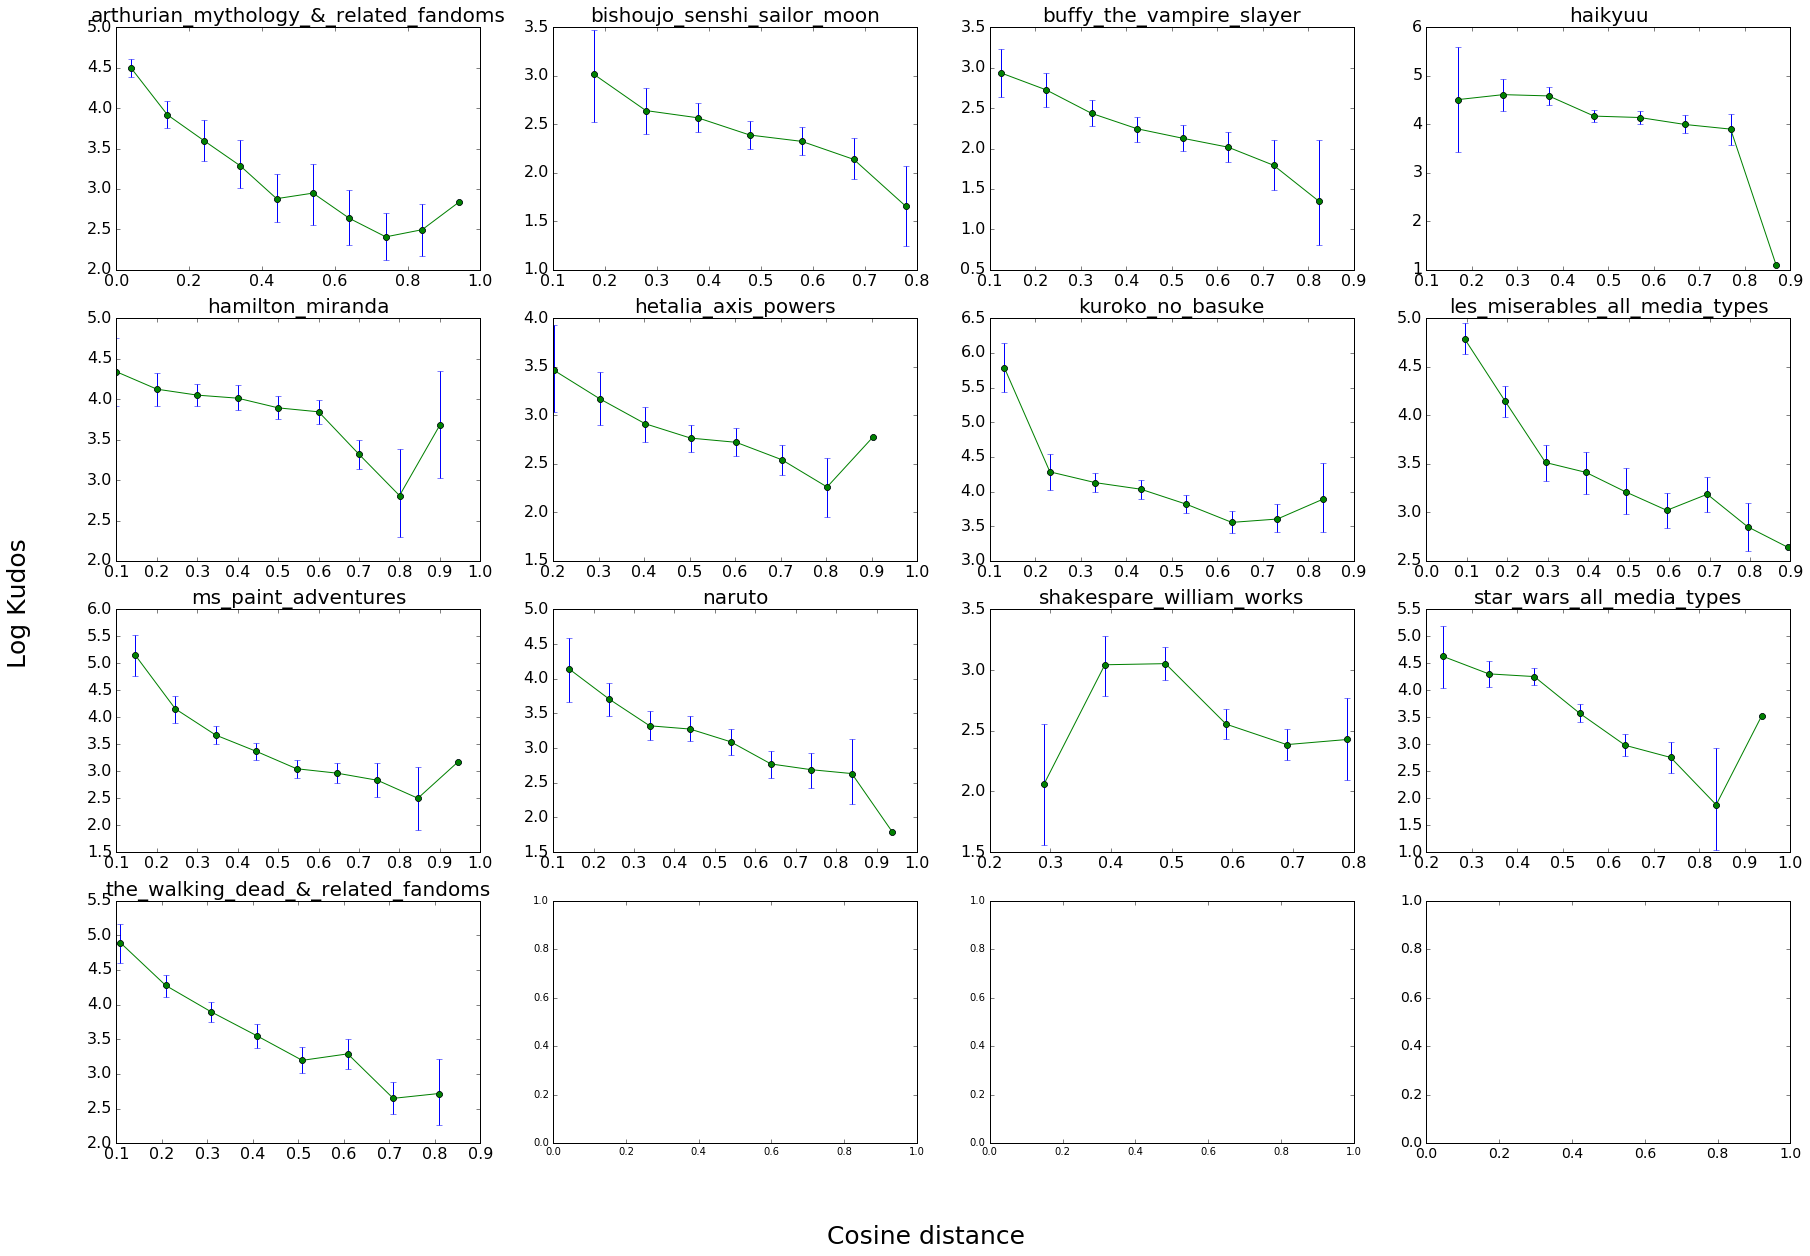

In [104]:
plot_scatter(fandom_list, dic)